# Early Movie Box Office Prediction by YouTube Trailer

According to Szolnoki et al, "Use of socially generated “big data” to access information about collective states of the minds in human societies has become a new paradigm in the emerging field of computational social science. A natural application of this would be the prediction of the society's reaction to a new product in the sense of popularity and adoption rate. However, bridging the gap between “real time monitoring” and “early predicting” remains a big challenge." Szolnoki et al put forward an unique way to predict the box office of the movie by the viewing and editing records on Wikipedia, the well-known online encyclopedia.

Their approach reminds us that movie companies release trailers to the market before the movie release date for people's review. There should be high correlations between popularity and box office. Why should we use trailers to predict the result? 

This project aims to use office trailers watching records on youtube, the most famous American video website, to predict domestic box office of the openning week.

## Table of Content
We will cover the following topics in this project:

- Installing the libraries
- Data Scraping
- Feature Selection
- Multivariate Linear Model for Box Office Prediction

## Installing the libraries

Before getting started, you'll need to install a python library supporting google api in order to retrieve data from Google YouTube Trailer data.

    $ pip install --upgrade google-api-python-client
    
Also, before calling api, you need to generate a api key from google YouTube Data API v3 and create a $client_secrets.json$ file with the api key. There are two types of key in Google Api: Api Key and Oauth 2.0 Credential. In this project, we use Api Key. Here is a detailed instruction on how to create a Api Key:

    https://developers.google.com/youtube/registering_an_application
    
After you run all the installs, make sure the following commands work for you:

In [1]:
import io
import json
import numpy as np
from googleapiclient.discovery import build
import requests
import json
import datetime
from bs4 import BeautifulSoup
import time
import re
import string
import nltk

%matplotlib inline
import matplotlib.pyplot as plt

## Data Scraping

Now, you have loaded the library. It's time to scrap data online. In order to make the prediction of future movie box office, we need to acquire data of previous movies, train these data with model and make the prediction.
    
In this project, we use data of 2015 movies as training data

In [2]:
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL. If the request fails, process will sleep for 1 seconds and try it again

    Args:
        url (string): 

    Returns:
        status_code (integer):
        raw_html (string): the raw HTML content of the response, properly encoded according to the HTTP headers.
    """
    response = None
    while response == None:
        try:
            response = requests.get(url)
        except:
            time.sleep(1)
    return response.status_code, response.content
    pass

First, we need to get all the movie from 2015. Here we use boxofficemojo.com as our data source. Since there is no API supported by BoxOfficeMojo, we use HTTP request to get HTML and parse the HTML and return a list of movies released on 2015. Due to the limitation of YouTube API used later, we only get the Top 100 movies sorted by domestic grosses.
The HTML of the website is not well formatted. Most HTML elements do not have a unique identification. In order to parse these data, we hard code in index number of the element. Accord to BoxOfficeMojoAPI [1], an unofficial Api that is deprecated right now, Box Office Mojo's site format changes daily, causing inconsistent data scraping from this API. We saved the data scraped in a file just in case the site format changes when the project runs later:
    
    box_office_2015.txt

Here is the url we use to scrape the data:
    
    http://www.boxofficemojo.com/yearly/chart/?yr=2015

In [4]:
# Movie 2015 top 100
boxoffice_mojo_base_url = 'http://www.boxofficemojo.com'

def retrieve_moive_yearly(year, num = 100):
    """
    Return a list of top num movies in a specific years

    Args:
        year (int):
        num (int): number of movie to load
        
    Returns:
        movies (list<dict>): A list of movies with their related information
        
    """
    _, html_doc = retrieve_html(boxoffice_mojo_base_url + '/yearly/chart/?yr=' + str(year))
    
    movies = []
    
    soup = BeautifulSoup(html_doc, 'html.parser')
    for m in soup.select('table')[6].select('tr')[2:2+num]:
        movie = {}
        movie['name'] = m.select('td')[1].select('a')[0].text
        movie_d = retrive_movie_box_office(m.select('td')[1].select('a')[0]['href'], movie['name'])
        if movie_d['budget'] == 0:
            continue
        movie.update(movie_d)
        movies.append(movie)
    return movies
    pass

After getting a list of movies, we need to get the detailed information of each movie including budget, release date and first-week box office. In this page, it has most information we need:

    http://www.boxofficemojo.com/movies/?page=weekly&id=starwars7.htm
    
The most difficult part is movie budget. As we know, the budget is not a known public number, the data is sometimes missing. For example, a movie called Daddy's Home does not have budget information on boxofficemojo. Although Wikipedia has the information of budget for most movies, the reason why we didn't use Wikipedia is it is hard to find corresponding Wikipedia for a specific Movie. For example, here are two movies without budget information on BoxOfficeMojo.com:
    
    Daddy's Home: https://en.wikipedia.org/wiki/Daddy's_Home_(film)
    The Woman in Black 2 Angel of Death: https://en.wikipedia.org/wiki/The_Woman_in_Black:_Angel_of_Death
    
The url pattern differs from film to film. In order to get the budget information, we use another source called THE NUMBERS  [2]. The website has the budget information of all the movies in their database on one page. Here is the URL:

    http://www.the-numbers.com/movie/budgets/all
    
In order to make sure the movie name can match between BoxOfficeMojo.com and the-numbers.com, we remove the all the punctuations and spaces, then compare between the name between these two sites. Even by doing a backup budget search, some movies still do not have budget information. For example A Walk in the Woods. We decide to exclude these data from the set.

In [5]:
def retrive_movie_box_office(movie_url, name = ""):
    """
    Return the budget and first week box office of a movie

    Args:
        movie_url (string): the movie url of BoxOfficeMojo.com
        name (string): the name of the movie
        
    Returns:
        movie (dict): A dictionary of budget and box office information
        
    """
        
    movie = {}
    _, html_doc = retrieve_html(boxoffice_mojo_base_url + movie_url)
    soup = BeautifulSoup(html_doc, 'html.parser')
    for table in soup.select('table'):
        if len(table.select('tr')) == 4:
            for tr in table.select('tr'):
                if 'Production Budget: ' in tr.text:
                    budget = tr.select('td')[1].text.replace('Production Budget: $','')
                    if 'million' in budget:
                        movie['budget'] = float(budget.replace('million','').strip()) * 1e6
                    elif 'thousand' in budget:
                        movie['budget'] = float(budget.replace('thousand','').strip()) * 1e3
                    elif 'billion' in budget:
                        movie['budget'] = float(budget.replace('billion','').strip()) * 1e9
                    else:
                        movie['budget'] = get_budget(name)
                    break
                if 'Release Date: ' in tr.text:
                    release = tr.select('td')[1].select('a')[0].text
                    movie['release'] = datetime.datetime.strptime(release, '%B %d, %Y')
    
    _, html_doc = retrieve_html(boxoffice_mojo_base_url + movie_url + '&page=weekly')
    soup = BeautifulSoup(html_doc, 'html.parser')
    for tr in soup.select('tr'):
        if len(tr.select('td')) == 9:
            if tr.select('td')[-1].text == '1':
                movie['boxoffice'] = int(tr.select('td')[2].text.replace('$','').replace(',',''))
                movie['theaters'] = int(tr.select('td')[4].text.replace(',',''))
    movie['name'] = name
    return movie

def get_budget(movie_name):
    """
    Search budget information of a movie

    Args:
        movie_name (string)
        
    Returns:
        budget (int): The budget of a movie, 0 if not found
        
    """
    
    movie_name = re.sub('\W', '', movie_name)
    _, html_doc = retrieve_html('http://www.the-numbers.com/movie/budgets/all')
    soup = BeautifulSoup(html_doc, 'html.parser')
    tds = soup.select('div#page_filling_chart td')
    find = False
    for i, td in enumerate(tds):
        if find:
            return int(td.text.replace('$','').replace(',',''))
        if movie_name in re.sub('\W', '', td.text):
            find = True
    return 0

The sample shows the budget information we get from the-numbers.com. The process is a little bit slow since the HTML element in this site is a little bit large and not well-formated (most tr tag does not have a close tag with it which causing the slow performance of BeautifulSoup).

In [7]:
get_budget('Daddy’s Home')

50000000

In [6]:
retrive_movie_box_office('/movies/?id=pixar2015.htm', 'Finding Dory')

{'boxoffice': 213317902,
 'budget': 200000000,
 'name': 'Finding Dory',
 'release': datetime.datetime(2016, 6, 17, 0, 0),
 'theaters': 4305}

Now, we will retrieve a 2015 movie list. Each item is a dictionary with corresponding movie information.

In [8]:
movie_list = retrieve_moive_yearly(2015)
print movie_list[0]

{'theaters': 4134, 'name': u'Star Wars: The Force Awakens', 'release': datetime.datetime(2015, 12, 18, 0, 0), 'budget': 245000000.0, 'boxoffice': 390856054}


After getting the movie list, we need to find the corresponding trailer on YouTube. We search the right trailer based on search result sorted by view count from YouTube. Here is the strategy of finding the right trailer:

The following table shows a list of films with their trailers' names on YouTube:

| Movie Name                            | Trailer Name                                                                    |
|---------------------------------------|---------------------------------------------------------------------------------|
| Avengers: Age of Ultron               | Marvel's "Avengers: Age of Ultron" - Teaser Trailer (OFFICIAL)                  |
| The Hunger Games: Mockingjay - Part 2 | The Hunger Games: Mockingjay Part 2 Official Trailer – “We March Together”      |
| The Hunger Games: Mockingjay - Part 1 | The Hunger Games: Mockingjay - Part 1 Official Trailer #1 (2014) - THG Movie HD |

You will find out that the official trailer of a movie does not have an obvious specific pattern. Also, sometimes the most viewed video on YouTube with the keyword combination of the name of movie and "trailer" is not the trailer itself (Unless the movie is really famous). For example, here is a search result of "Inside Out Trailer" (the video on top has the highest view count):

| "Inside Out Trailer" search result                                        |
|---------------------------------------------------------------------------|
| 'INSIDE OUT' Makeup Tutorial (Disgust,Sadness,Joy,Anger & Fear)           |
| Disgust & Anger - Disney's INSIDE OUT Movie Clip                          |
| Inside Out - ALL Clips (Sneak Peek)                                       |
| Inside Out2 Parody - Movie Trailer (2017)                                 |
| INSIDE OUT - “We are not eating that” Clip (2015) Pixar Animated Movie HD |
| Inside Out - Riley Without Emotions                                       |
| Inside Out Extended Clip                                                  |
| Inside Out Trailer 2 UK - Official Disney Pixar  HD                       |

After analyzing all the movies in our list, We found out the name of a movie trailer has the following patterns:
- It only contains the word of the movies and the type of the trailer before "Trailer" word in most situations.
- There are usually four types of the trailer: Final, Teaser, Official and Announcement. There are also some other types of trailer, for example, Comic-Con Trailer. However, the most viewed trailer are of the above types.
- If it has other keywords before "Trailer", it is usually the movie maker's name. For example, the trailer of "Avengers" has its movie maker "Marvel" at the beginning
- Most additional information of a trailer is behind "Trailer" word
- The published date of a movie trailer is usually between the released date and one year before the release date. This prevents finding the wrong trailer of a series movies

Based on these patterns, we came up with a list of keywords containing the most frequent keywords of a movie trailer. Here is the process of comparing between the name of a trailer and a movie:
1. Replace all the non-letter word with whitespace of a movie name and tokenize it and concatenate with keyword list (set 1)
2. Replace all the non-letter word with whitespace of a trailer name, tokenize all the words before "Trailer" if it exists (set 2)
3. Find all the word in set 2 not in set 1
4. If the result contains at least one word, it is not the correct trailer

The reason we allow 0 tolerance between movie name and trailer name is to prevent the names of two movies with only one word difference

In [10]:
CLIENT_SECRETS_FILE = "client_secrets.json"
YOUTUBE_API_SERVICE_NAME = "youtube"
YOUTUBE_API_VERSION = "v3"

def load_client():
    """
    Load Google API client with client key

    Returns:
        client (object): The Google API client
        
    """
    with io.open(CLIENT_SECRETS_FILE) as cred:
        YOUTUBE_API_KEY = cred.readline().strip()

    return build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=YOUTUBE_API_KEY)

Here is the API reference we use to get a list of videos:

    https://developers.google.com/youtube/v3/docs/search/list

In [11]:
def youtube_search(query, release_date, max_results = 20):
    """
    Search the top-viewed trailer of a movie

    Args:
        query (string): the name of the movie
        release_date (datetime): the date of movie release date
        max_results (int): maximum of result returned from google api
        
    Returns:
        movies (list<dict>): A list of trailers for the movie
        
    """
    
    search_response = youtube.search().list(
        q=query + ' trailer',
        part="id,snippet",
        maxResults=max_results,
        order="viewCount" ,
        publishedBefore= release_date.strftime('%Y-%m-%dT00:00:00Z'),
        publishedAfter= (release_date + datetime.timedelta(days = 365)).strftime('%Y-%m-%dT00:00:00Z')
    ).execute()

    videos = []
    channel_title = ''

    for search_result in search_response.get("items", []):
#         print search_result["snippet"]["title"]
        if search_result["id"]["kind"] == "youtube#video" and is_trailer(query, search_result["snippet"]["title"]):
            video = {}
            video['id'] = search_result["id"]["videoId"]
            video['title'] = search_result["snippet"]["title"]
            video['publish_at'] = search_result["snippet"]["publishedAt"]
            videos.append(video)
            break
    return videos

def is_trailer(movie_name, video_name):
    """
    Compare the movie name and video name to tell whether the video is the trailer of this movie

    Args:
        movie_name (string)
        video_name (string)
        
    Returns:
        is_trailer (bool): Whether this video is the trailer of this movie
        
    """
    regex = re.compile('[^a-zA-Z]')
    trailer_keywords = ['trailer', 'hd', 'official', 'teaser', 'announcement', 'final', 
                        'marvel', 's', 'us', 'disney', 'pixar', 'movie']

    index = video_name.lower().find('trailer')
    
    video_name = video_name if index == -1 else video_name[:index]
    video_tokens = nltk.word_tokenize(regex.sub(' ', video_name.lower()))
    
    movie_tokens = nltk.word_tokenize(regex.sub(' ', movie_name.lower()))
    
    if (len(set(video_tokens) - set(movie_tokens + trailer_keywords)) > 0):
        return False
    else:
        return True

In [12]:
print is_trailer('Rogue One: A Star Wars Story', 'Rogue One: A Star Wars Story Trailer #2 (Official)')
print is_trailer('The Hunger Games: Mockingjay Part - 2', 'The Hunger Games: Mockingjay Part 2 Official Trailer – “We March Together”')
print is_trailer('Sisters', 'Sisters Location Trailer')

True
True
False


In [13]:
youtube = load_client()
youtube_search('Inside out', datetime.datetime(2015,12,17))

[{'id': u'_MC3XuMvsDI',
  'publish_at': u'2014-12-10T17:00:22.000Z',
  'title': u'Inside Out Trailer 2 UK - Official Disney Pixar | HD'}]

In [14]:
def load_trailers(movies):
    """
    Load the trailers of all the movies

    Args:
        movies (list<dict>)
        
    Returns:
        trailers (list<dict>): List of trailers with their information
        
    """
    return [youtube_search(movie['name'], movie['release'])[0] for movie in movies]

In [15]:
trailers = load_trailers(movie_list)

After reviewing all the result retrieved based on the above strategy, we find that the results are surprising accurate. We can find corresponding trailer for all the movies in our list. The following part shows the trailers of first five movies.

In [88]:
for i in range(3):
    print movie_list[i]['name']
    print trailers[i]['title']
    print '==================='

Star Wars: The Force Awakens
Star Wars: The Force Awakens Trailer (Official)
Jurassic World
Jurassic World - Official Trailer (HD)
Avengers: Age of Ultron
Marvel's "Avengers: Age of Ultron" - Teaser Trailer (OFFICIAL)


Now it's time to get the video information based on video id. Due to the limitation of YouTube API, only channel owner can view the history data of a channel, we decide to use another API provided by a third party: ChannelMeter [3]. It is a RESTful API that user can query history YouTube data based on searching criteria. Here is the base url:

    https://api.channelmeter.com/v3/youtube/query
    
** IMPORTANT: The trail version of this API is only 15 days, we will stop using this API after December 25th, 2016. If anyone uses this API after this date, we are not responsible for any consequence. **
    
The following table shows a detailed information about this API. Until now, there is no official documentation associated with this API.
    
| Field   | Description                                                                                                                    | Value                                                                       |
|---------|--------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| id      | The type of the resource and its id. Potential types are Channel and Video                                                     | video:videoid                                                               |
| start   | The start date of data                                                                                                         | 2015-06-25                                                                  |
| end     | The end date of data                                                                                                           | 2015-06-26                                                                  |
| group   | The group of data returned by API                                                                                              | Day, Week, Month, Channel/Video,  Category, Duration, Day of Week, % Growth |
| measure | Whether the data is cumulative or periodic. The default value is periodic                                                      | cumulative                                                                  |
| metric  | The metrics of return data. If you want to retrieve different metrics,  create a metrics equation for each one and join with & | views, comments, likes, dislikes,  ratings, uploads, subscribes             |

This API returns a JSON result. All the video-related data is stored in *data* field. Here is a sample request with its result: 

**Request**

[https://api.channelmeter.com/v3/youtube/query?id=video:sGbxmsDFVnE&metric=views&start=2016-11-11&end=2016-11-12&group=day&measure=cumulative](https://api.channelmeter.com/v3/youtube/query?id=video:sGbxmsDFVnE&metric=views&start=2016-11-11&end=2016-11-12&group=day&measure=cumulative)


**Response**
```json
    {
        "data": [[[1478851200],[95355363]],[[1478937600],[95368175]]],
        "groups": ["day"],
        "metrics":["views"],
        "names":["Star Wars: The Force Awakens Trailer (Official)"]
     }
```
The *data* field is a list. Each item is a date and the data of the video for that date. The *date* is the total seconds from 1970/1/1. For example 1478851200 is the total seconds from 1970/1/1 to 2016/11/11. After running the API for different videos and different dates, we found out that the data is **incomplete**. Some videos do not have any data associated with it. Also, some videos do not have data on a specific date. We ignore the movie with no data but keep the movie with missing data on some days.

In [17]:
def youtube_trailer_data(video_id, start, end, metrics='views'):
    """
    Load trailer statistics information

    Args:
        video_id (string)
        start (datetime): the start date of statistics information
        end (datetime): the end date of statistics information
        metrics (string): the metrics of statistics information, each metrics is separated by comma
        
    Returns:
        trailers (numpy.array): list on information for each date
        
    """
    result = []
    ms = '&'.join(['metric=' + m for m in metrics.split(',')])
    query = 'https://api.channelmeter.com/v3/youtube/query?'
    query += 'id=video:{0}&start={1}&end={2}&{3}&group=day&measure=cumulative'.format(
                video_id, start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"), ms)
    response = json.loads(retrieve_html(query)[1])
    if 'error' not in response:
        try:
            result = np.array(response['data'])
        except:
            return result
    else:
        print response
    return result

In [20]:
data = youtube_trailer_data('RFinNxS5KN4', datetime.datetime(2015,5,11), datetime.datetime(2015,6,11), 'views,comments')
print data[0]

[[1433833200] [62546160, 55320]]


Now let's combine everything together.

In [21]:
def load_one_day_movie_data(trailers, movies, time_interval = 1):
    """
    Load one day statistic information of all the trailer

    Args:
        trailers (list<dict>)
        movies (list<dict>)
        time_interval (int): number of day before the release date
        
    Returns:
        data (list): list on statistic information for all the movies
        box_office (list): list of first week box office information
        name (list): list of movie name
        
    """
    data, box_office, name = [], [], []
    
    for i, movie in enumerate(movies):
        movie_data = youtube_trailer_data(trailers[i]['id'], 
                                        movie['release'] - datetime.timedelta(days = time_interval), 
                                        movie['release'] - datetime.timedelta(days = time_interval), 
                                        'views,comments,likes,dislikes,ratings')
        if len(movie_data) == 0:
            continue
        else:
            movie_data = movie_data[:,1].flatten()[0]
        movie_data.append(movie['budget'])
        movie_data.append(movie['theaters'])
        data.append(movie_data)
        box_office.append(movie['boxoffice'])
        name.append(movie['name'])
    return data, box_office, name

In [24]:
def load_100_day_movie_data(trailers, movies):
    """
    Load 100 days statistic information of all the trailer

    Args:
        trailers (list<dict>)
        movies (list<dict>)
        
    Returns:
        data (ndarray): list on statistic information for all the movies
        box_office (list): list of first week box office information
        
    """
    interval = 100
    box_office = np.zeros((100))
    yt_data = np.zeros((interval, 100, 5))
    for movie_i, movie in enumerate(movies):
        start =  movie['release'] - datetime.timedelta(days = interval)
        movie_data = youtube_trailer_data(trailers[movie_i]['id'],
                                        start,
                                        start + datetime.timedelta(days = interval-1),
                                        'views,comments,likes,dislikes,ratings')
        if len(movie_data) == 0:
            continue
        for data in movie_data:
            day = (datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds = long(data[0][0])) - start).days
            yt_data[day][movie_i] = np.array(data[1])
        box_office[movie_i] = movie['boxoffice']
    return np.array(yt_data), np.array(box_office)

## Feature Selection

From our perspective, more people are interested in the trailer implies more box office of the movie.
In order to predict domestic box office, we selected five time-varying variables of official trailers from youtube.
- The number of the people watch the trailer
- The number of comments under the trailer
- The number of likes of the trailer
- The number of dislikes of the trailer
- The rating of the trailer


In addition, we believe the number of theater play the movie and movie budget are related to the box office at some extent. So, we use the following two constants as features.
- The number of the theaters play this film in the opening week
- The budget of the film



### Feature Correlation to Box Office

In order to proof our assumption that the above seven features are related to box office, we use to Pearson correlation coefficient to validate these features. Here is the specific steps:

- Generate accumulative values of the variables 100 days from the movie realese date.
- Calculate the Pearson correlation coefficient of variables and constants per feature per day.
- Show Pearson correlation coefficients day by day on the plot and show the trends

In [25]:
# load data 100 days before the movie release date
youtube = load_client()
yearly_data100 = load_100_day_movie_data(trailers, movie_list)

In [37]:
youtube = load_client()
yearly_data = load_one_day_movie_data(trailers, movie_list)

In [38]:
from scipy import stats

# calculate the Pearson correlation coefficient for five time varying variables
def pearsonr_byday(movie_data):
    features_correlation = {}
    days = len(movie_data[0])
    
    for feature in range(len(movie_data[0][0][0])):
        
        correlation_bydate = []
        for day in range(days): 
            
            # remove data missing rows
            points = \
                zip(*[(i[0], i[1]) for i in zip(np.array(movie_data[0][day])[:, feature].flatten(), movie_data[1]) \
                                                                                             if i[0] <> 0.0])
            # calculate the Pearson correlation coefficient 
            correlation_bydate.append((-(days-day), stats.pearsonr(points[0], points[1])))
            
        features_correlation[feature] = correlation_bydate
    return features_correlation
    pass

features_correlations = pearsonr_byday(yearly_data100)

In [39]:
# calculate the Pearson correlation coefficient for two constants
theater = zip(*[(i[0], i[1]) for i in zip(np.array(yearly_data[0])[:,-1], yearly_data[1]) if i[0] <> 0.0])
theater_corr = stats.pearsonr(theater[0], theater[1])

budget = zip(*[(i[0], i[1]) for i in zip(np.array(yearly_data[0])[:,-2], yearly_data[1]) if i[0] <> 0.0])
budget_corr = stats.pearsonr(budget[0], budget[1])

views : y=0.000174x+(0.800347)
comments : y=0.000903x+(0.836651)
likes : y=0.000835x+(0.849351)
dislikes : y=0.001120x+(0.536000)
ratings : y=0.000828x+(0.847692)


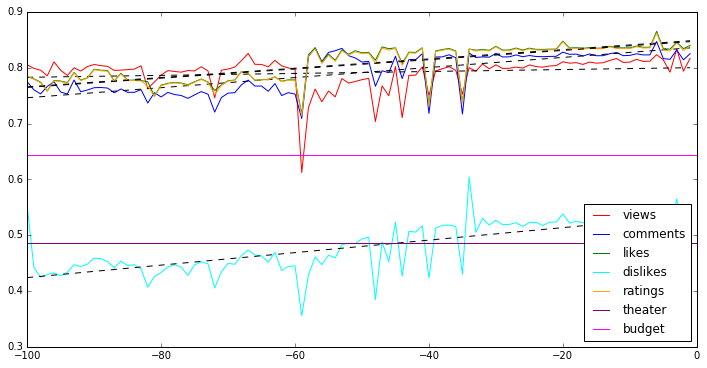

In [40]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

colors = ['red','blue','green','cyan','orange','purple','magenta']
labels = ['views','comments','likes','dislikes','ratings','theater','budget']

plt.figure(figsize=(12,6))
lines = []
for k, v in features_correlations.iteritems():
    x = zip(*v)[0]
    y = zip(*zip(*v)[1])[0]
    lines.append(plt.plot(x,y, color = colors[k], label = labels[k])[0])

    # calc the trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--", color = 'black')
    # the line equation:
    print labels[k], ": y=%.6fx+(%.6f)"%(z[0],z[1])
# draw constants
lines.append(plt.plot((0,-100),(theater_corr[0],theater_corr[0]), color = colors[k+1], label = labels[k+1])[0])
lines.append(plt.plot((0,-100),(budget_corr[0],budget_corr[0]), color = colors[k+2], label = labels[k+2])[0])
# print lines
plt.legend(handles= lines,loc =4)
plt.show()

### Results

The above figure shows Pearson correlation coefficient of seven features we selected. The axis x represents t days before the release date, for example -80 means 80 days before the release date. The axis reports the Pearson correlation coefficient of that feature value from 0 to 1. 

According to the results, all time-varying variables shows increasing correlation to the box office. The correlations of views, comments, likes, and ratings reach 0.85 above couples of days before the release. 

In addition, the correlations become stable 30 days before the release, which means it is possible to predict a relatively accurate box office one month early basing on youtube trailer data. 

## Multivariate Linear Model for Box Office Prediction

We tried different ways to establish the linear regression model, namely gradient descent and generalized linear regression. 

### Gradient Descent

In this way, we get the initial value of $\theta_1$ and $\theta_2$ by solving the matrix at first. Then we use the following gradient descent formular to decrease the loss $\frac{1}{m}\Sigma(h_\theta(x^i) - y^i))^2$. By repeating the gradient descent step, we can get the trained $\theta_1$ and $\theta_2$ to make better prediction.

$$\theta_1 := \theta_1 - \alpha \frac{1}{m} \Sigma(h_\theta(x^{(i)}) - y^{(i)})) \times x^{(i)} $$

$$\theta_2 := \theta_2 - \alpha \frac{1}{m} \Sigma(h_\theta(x^{(i)}) - y^{(i)})) $$
    
### Validation
Regarding to validation, we believe using precentage error to compare the predict results is more reasonable. For example, the box office of movie A is 24 millions and our prediction is 20 millions (4 millions loss and 16.67% loss); the box office of movie B is 1 million and our prediction is 0.1 million (0.9 million loss and 90% loss). Considering the above example, we think it is more reasonable to use precentage error to evaluate the results. 


In [41]:
class linear_model:
    def __init__(self, X, y, reg = 1e-4):
        # coefficient to decrease the value in matrix
        self.e = float(1e6)
        self.X = X / self.e
        self.y = y / self.e
        self.reg = reg
        self.theta1 = np.zeros(X.shape[1])
        self.theta2 = 0
   
    def gradient1(self):
        """
        Calculate gradient for theta1

        Returns:
            g1 (numpy.array): 1D numpy array containing the gradient

        """
        err = np.dot(self.X, self.theta1) + self.theta2 - self.y
        g1 = np.mean(err.reshape(len(self.y),1) * self.X, axis = 0)
        return g1
        pass
    
    def gradient2(self):
        """
        Calculate gradient for theta2

        Returns:
            g2 (numpy.array): 1D numpy array containing the gradient

        """
        err = np.dot(self.X, self.theta1) + self.theta2 - self.y
        g2 = np.mean(err)
        return g2
        pass

    def get_theta1(self):
        """
        Calculate the initial theta1
        
        """
        self.theta1 = np.linalg.solve(self.X.T.dot(self.X-np.mean(self.X, axis = 0)) + self.reg*np.eye(self.X.shape[1])\
                                 ,self.X.T.dot(self.y - np.mean(self.y))) 
        pass
    
    def get_theta2(self):
        """
        Calculate the initial theta2
        
        """
        self.theta1 = np.mean(self.y) - np.mean(self.X, axis =0).dot(self.theta1.T) - self.reg/float(len(self.y))
        pass
    
    def train(self, niters=100, learning_rate=0.001):
        """ 
        Train the linear regression with the given parameters. 
            
        Args:
            niters (int) : the number of iterations of gradient descent to run
            learning_rate (float) : the learning rate (or step size) to use when training
        """
        self.get_theta2()
        self.get_theta1()
        for i in range(niters):
            self.theta2 -= learning_rate*self.gradient2()
            self.theta1 -= learning_rate*self.gradient1()
#             if i % 1000 == 0:
        print "training round %d, loss: %f" % (i, self.validation())
        pass
    
    def validation(self):
        """ 
        Return the objective of current model
        
        """
        return np.mean(np.square(np.dot(self.X, self.theta1) + self.theta2 - self.y))
        pass
    
    def predict(self, X):
        """ 
        Predict the value of value in X. 
            
        Args: 
            X(array_like) : array of examples, where each row is an example
            
        Return:
            prediction(vector) : 1D numpy array containing predicted values
        """
        return (np.dot(X / self.e, self.theta1) + self.theta2) * self.e
        pass

When we run the model with training data, we find out that the error increase greatly and reach infinite number soon. We thing the reason why the model does not work with the current training dataset is large number. And the system cannot handle a larget float. In order to solve this problem, we think of two solution: using log or divide by a large number. In this linear regression model, we use a term **e** to solve this problem, the value of **e** is **1e6**

### Generalized Linear Regression

By following this way, there are no needs to train the data. We can get the best $\theta$ directly.

$$\theta = (X^T X)^{-1} X^T y$$

Comparing to above approach, it is an easier and more standard approach. However, after comparing the results, we found gradient descent approah works better. 


In [42]:
class linear_regression:
    def __init__(self, X, y):
        X1 = np.ones((X.shape[0], X.shape[1] + 1))
        X1[:,1:] = X
        self.theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
    
    def predict(self, X):
        """ 
        Predict the value of value in X. 
            
        Args: 
            X(array_like) : array of examples, where each row is an example
            
        Return:
            prediction(vector) : 1D numpy array containing predicted values
        """
        return np.dot(X, self.theta)
        pass

Here is the result of these two models. The predicted error is in dollars. As you can see the result is pretty the same. The linear regression using gradient descent is little better than the other one

In [67]:
x1 = np.array(yearly_data[0])
y1 = np.array(yearly_data[1])
x1[:,5] = x1[:,5] / float(10)

LM = linear_model(x1, y1)
LM.train(10000)
predicts_1 = LM.predict(x1)
print 'predicted error($):' + str(np.mean(np.abs(predicts_1 - y1)))

predicts_2 = linear_regression(x1,y1).predict(x1)
print 'predicted error($):'+ str(np.mean(np.abs(predicts_2 - y1)))

training round 9999, loss: 757.219678
predicted error($):17908646.4585
predicted error($):18678506.2634


The following diagram shows the distribution of error ratio.

In [68]:
from collections import Counter 

def show_loss(predicted, box_office, size = 400):
    loss = np.sort((abs(predicted - box_office)/box_office)*100)
    interval = 10
    loss = np.ceil(loss / interval)*10
    data = Counter(loss)

    plt.figure(figsize=(20,5))
    plt.bar(zip(*data.items())[0], zip(*data.items())[1])
    plt.xlim([0, size])
    plt.xlabel('Loss Precentage')
    plt.title('Loss')

    plt.show()
    
    pass

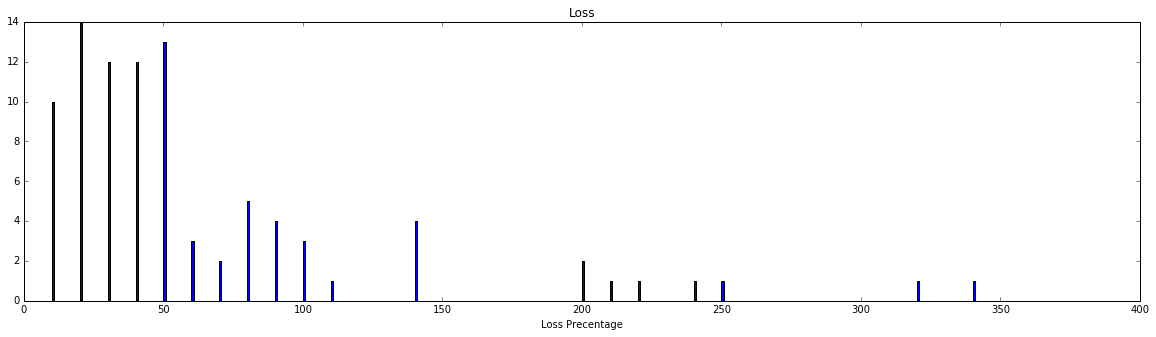

In [69]:
show_loss(predicts_1, y1)

From the diagram, we can find that most error stays within 50%. There are some outliers that we find affect the result greatly, we will take two movie as examples:

- The Revenant
- The Big Short

The reason we found is the theater number during the first week:  only 4 theaters has *The Revenant* and only 8 theaters has *The Big Short*. Even though there is a high correlation between the number of theater and box office, these two examples is too extreme that the results are still far away from their acutal values

Based on the following plots, we found that the prediction of most movies are pretty close to the actual result for both linear model. 

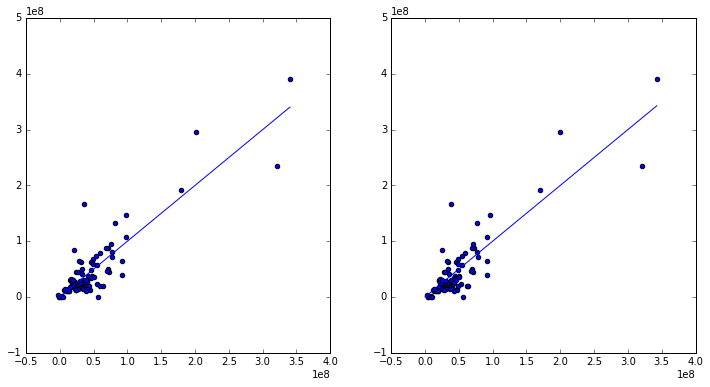

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)

# plot prediction using linear regression gradient descendent
plt.scatter(predicts_1, y1)
plt.plot([0,np.max(predicts_1)],[0,np.max(predicts_1)])

# plot prediction using linear model
plt.subplot(1, 2, 2)
plt.scatter(predicts_2, y1)
plt.plot([0,np.max(predicts_2)],[0,np.max(predicts_2)])
plt.show()

## Future Prediction
Now, let's make a prediction of one movies of 2016: **Doctor Strange**.

In [46]:
def load_one_movie_data(url, movie_name):
    movie_data = retrive_movie_box_office(url, movie_name)

    trailer = youtube_search(movie_name, movie_data['release'])

    start = movie_data['release']  - datetime.timedelta(days = 30)
    movie_stat = youtube_trailer_data(trailer[0]['id'], start, start, 'views,comments,likes,dislikes,ratings')
    stats = movie_stat[0][1]
    stats.append(movie_data['budget'] / 10)
    stats.append(movie_data['theaters'])
    return stats, movie_data['boxoffice']

stats, boxoffice = load_one_movie_data('/movies/?id=marvel716.htm', 'Doctor Strange')

In [47]:
prediction = LM.predict(np.array([stats]))[0]
print 'prediction: ' + str(prediction) # - boxoffice
print 'actual: ' + str(boxoffice)
print 'difference: ' + str(prediction - boxoffice)
print 'error rate: {0:.0f}%'.format((prediction - boxoffice) / boxoffice * float(100))

prediction: 114979632.593
actual: 109982169
difference: 4997463.59309
error rate: 5%


And then we will predict a up-coming movie: **Rogue One: A Star Wars Story**. Since the movie is on show right now, most movie-related data is not available online. We will manually enter the release date and budget.

For the number of theaters, we will assume there are 4000 theaters.

In [48]:
trailer = youtube_search('Rogue One: A Star Wars Story', datetime.datetime(2016,12,16))

start = datetime.datetime(2016,12,16)  - datetime.timedelta(days = 30)

movie_stat = youtube_trailer_data(trailer[0]['id'], start, start, 'views,comments,likes,dislikes,ratings')

stats = movie_stat[0][1]
stats.append(20000000)
stats.append(4000)

prediction = LM.predict(np.array([stats]))[0]
print 'prediction: ' + str(prediction) # - boxoffice

prediction: 236204665.587


## Future Work
Right now, there are only seven features. We tried to find more features that might help the model to increase it's accuracy. One feature we think of is the review content and performs a sentiment analysis on these reviews. The reason we choose this feature is because it represents more about how people think about the trailer. By analyzing the comments, it provides a rough rating of the trailer besides the existing statistics. However, the result we found is not as good as what we expected. This part shows our analysis

First, let's load the comments from YouTube API.

In [49]:
def youtube_comment(video_id):
    comments = []
    pageToken = ''
    while 1:
        results = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=pageToken,
            textFormat="plainText"
        ).execute()

        for item in results["items"]:
            comment = {}
            top_level_comment = item["snippet"]["topLevelComment"]
            comment['text'] = top_level_comment["snippet"]["textDisplay"]
            comment['published_at'] = top_level_comment["snippet"]['publishedAt']
            comment['like'] = top_level_comment["snippet"]["likeCount"]
            comments.append(comment)
        
        if 'nextPageToken' not in results:
            break
        else:
            pageToken = results['nextPageToken']
    return comments

In [50]:
# Fantastic Beasts and Where to Find Them - Teaser Trailer [HD]
comments = youtube_comment('ViuDsy7yb8M')

In [89]:
print len(comments)
print np.array(comments)[:2]

8639
[ {'text': u'For an expelled student he is really good at apparating\ufeff', 'published_at': u'2016-12-11T10:25:44.000Z', 'like': 0}
 {'text': u'Hate the woman in this movie\ufeff', 'published_at': u'2016-12-11T06:26:27.000Z', 'like': 0}]


The library we use to perform sentiment analysis is NLTK. NLTK provides two ways to perform sentimental analysis. Our implementation is based on this webpage:

    http://www.nltk.org/howto/sentiment.html
    
Before running the following code, make sure **twython** is installed

    $ pip install twython

The first method return a polarity score for each comments. It is a number ranged from -1 to 1. High number means positive and Low number means negative. After getting this number, we normalize this number to 0 to 10 and calculates the means value of these comments. We also calculate a weighted mean value. The weight is how many people like this comments.

In [55]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
from nltk import tokenize

scores1 = []

sid = SentimentIntensityAnalyzer()
for comment in comments:
    ss = sid.polarity_scores(comment['text'])
    scores1.append(((ss['compound'] + 1) * 5, comment['like']))

After calculating the these two mean values, we found out that the comments is kind of neutral

In [56]:
print np.mean([score[0] for score in scores1])
total = sum([score[1] for score in scores1])
print np.sum([score[0] * score[1] / total for score in scores1])

5.48383933326
5.6615147095


After reviewing several comments, we found out the algorighm is not accurate. For example the following examples show that some comments cannot be interrepted correctly

In [58]:
print sid.polarity_scores("I looooooooove this movie")
print sid.polarity_scores("I am dying to watch this movie")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


# Reference
1. BoxOfficeMojoAPI, https://github.com/earthican/BoxOfficeMojoAPI
2. The Numbers, http://www.the-numbers.com
3. ChannelMeter, https://channelmeter.com/
4. Andrew Ng, Generalized Linear Models, https://datajobs.com/data-science-repo/Generalized-Linear-Models-[Andrew-Ng].pdf
5. Gradient Descent for Linear Regression, https://www.coursera.org/learn/machine-learning/lecture/kCvQc/gradient-descent-for-linear-regression
6. Sentiment Analysis using NLTK, http://www.nltk.org/howto/sentiment.html
7. Early Prediction of Movie Box Office Success Based on Wikipedia Activity Big Data, http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0071226